In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from netCDF4 import Dataset

with Dataset("simulatedObs_sample.nc") as fh:
    tb=fh["tb"][:,:]
    iwc_SSRG=fh["iwc_SSRG"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    
iwpL=[]
iwc_gcL=[]
h=np.arange(50)*0.24 # relative height of each layer
import tqdm
iwc_SSRGL=[]
zKuL=[]
pnormL=[]
tbObsL=[]
for i,iwc in tqdm.tqdm(enumerate(iwc_SSRG)):
    if(iwc.sum()>0.01):
        a=np.nonzero(iwc>0.001)
        if len(a[0])>2:
            iwpL.append(iwc.sum()*0.24)
            hgc1=(iwc[a]*h[a]).sum()/iwc[a].sum()
            iwc_gcL.append(hgc1)
            iwc_SSRGL.append(iwc)
            zKuL.append(zKu[i])
            pnormL.append(pnorm[i])
            tbObsL.append(tb[i])

#set random seed
np.random.seed(42)
tbObsL=np.array(tbObsL)
iwpL=np.array(iwpL)
iwc_gcL=np.array(iwc_gcL)
iwc_SSRGL=np.array(iwc_SSRGL)
zKuL=np.array(zKuL)
pnormL=np.array(pnormL)

nt,nchan=tbObsL.shape   
lidarNoise=np.random.randn(nt,50)*0.1
pnorm=np.log10(1e-3*(pnormL)*10**lidarNoise+1e-9)  #add noise to pnorm
# pnorm is in sr^-1 m^-1 units
pnorm[pnorm<-8.0]=-8.0
pnormMax=pnorm.max(axis=-1)
nt2,nchan=tb.shape

zKuL+=np.random.randn(nt,50)
zKuL[zKuL<8]=0
print(nt/nt2)



165078it [00:07, 21401.72it/s]


1.0


In [30]:
# save a subset of the tb, pnorm, zKu, and iwc_SSRG using xarray
# this was used to subsample the initial dataset which is too large to upload to github
import xarray as xr
nt=tbObsL.shape[0]
ind=np.random.randint(0,nt,int(nt*0.25))
ds=xr.Dataset({"tb":(["nt","nchan"],tbObsL[ind]),
                "pnorm":(["nt","nz"],pnormL[ind]),
                "zKu":(["nt","nz"],zKuL[ind]),
                "iwc_SSRG":(["nt","nz"],iwc_SSRGL[ind])})
encoding={"tb":{"zlib":True,"complevel":9},
            "pnorm":{"zlib":True,"complevel":9},
            "zKu":{"zlib":True,"complevel":9},
            "iwc_SSRG":{"zlib":True,"complevel":9}}
ds.to_netcdf("simulatedObs_sample.nc",encoding=encoding)

In [32]:
print(nt)
nt=tbObsL.shape[0]
tbObsL+=np.random.randn(nt,nchan)*3


165078


In [33]:
#import train_test_split
from sklearn.model_selection import train_test_split
nt=tbObsL.shape[0]
yobsLidarRadar=np.concatenate((pnorm,zKuL),axis=-1)
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), iwc_SSRGL[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)

X1_train=yobsLidarRadar[ind_train,:]
X1_test=yobsLidarRadar[ind_test,:]
iwc_train=iwc_SSRGL[ind_train,:]
iwp_train=iwc_train.sum(axis=-1)*0.24
iwc_test=iwc_SSRGL[ind_test,:]
iwp_test=iwc_test.sum(axis=-1)*0.24
iwc_gc_train=iwc_gcL[ind_train]
iwc_gc_test=iwc_gcL[ind_test]

In [39]:
# used a lazy linear regression to estimate iwc_gc and iwp from combinations of lidar, radar, and radiometer observations
# in this example, we are using faiss, which is a library for fast nearest neighbor search
# this correspons to a  "lazy" model, because no parameterizations are derived and the original training data is needed to make predictions
# however, the model is robust and fast
# results are not significantly different from the results in the paper
# however if the training data needs to be extended, the model might not be as convenient as a parameterized one as it needs the training rather
# than information extracted from it

import faiss
d=X1_train.shape[1]
index = faiss.IndexFlatL2(d)   # build the index
index.add(X1_train.astype(np.float32))                  # add vectors to the index
D,I=index.search(X1_test.astype(np.float32),15)     # actual search
iwc_gc_retL=[]
iwp_retL=[]
for d1,i1 in zip(D,I):  # gravity centers and IWP are estimated as the weighted average of the 15 nearest neighbors
    if d1.max()<1e-6:
        d1+=1e-6
    iwc_gc_retL.append((iwc_gc_train[i1]*d1).mean()/d1.mean()) 
    iwp_retL.append((iwp_train[i1]*d1).mean()/d1.mean())

In [36]:
#compute the normalized root mean square error
def nrms(iwc1,iwc2):
    return np.sqrt(np.mean((iwc1.flatten()-iwc2.flatten())**2))/np.sqrt(np.mean(iwc1.flatten()**2))

print("nrms iwc:",nrms(iwc_gc_test,np.array(iwc_gc_retL)))
print("nrms iwp:",nrms(iwp_test,np.array(iwp_retL)))

nrms iwc: 0.10139018123307823
nrms iwp: 0.46132848302262813


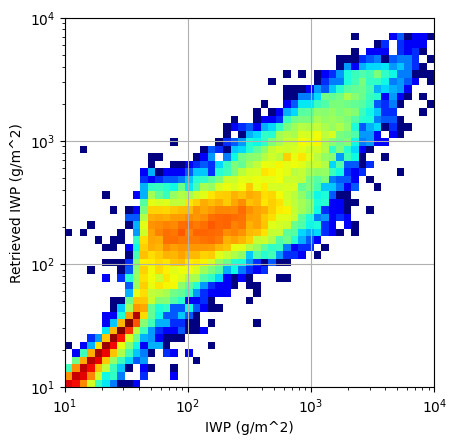

In [37]:
# do some plots
import matplotlib.pyplot as plt
import matplotlib
xbins=np.logspace(1,4,50)
plt.figure()
ax=plt.subplot(111)
plt.hist2d(iwp_test*1e3,np.array(iwp_retL)*1e3,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap="jet")
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.xlabel("IWP (g/m^2)")
plt.ylabel("Retrieved IWP (g/m^2)")
plt.grid()

Text(0, 0.5, 'Retrieved IWC GC (km)')

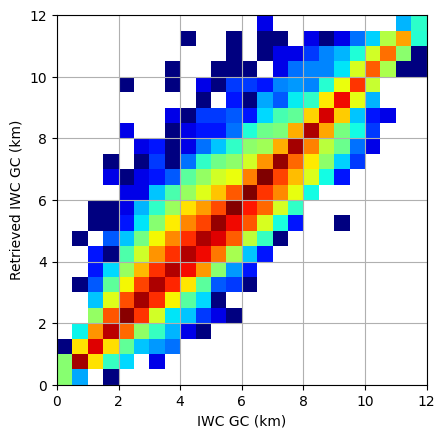

In [38]:
#y_pred_gc=lgbmReg_IWC_GC.predict(X1_test)
#print(np.corrcoef(y_pred_gc,iwc_gc_test))
import matplotlib.pyplot as plt
import matplotlib
xbins=np.logspace(1,4,50)
plt.figure()
ax=plt.subplot(111)
plt.hist2d(iwc_gc_test,iwc_gc_retL,bins=np.arange(25)*0.5,norm=matplotlib.colors.LogNorm(),cmap="jet")
ax.set_aspect('equal')
plt.grid()
plt.xlabel("IWC GC (km)")
plt.ylabel("Retrieved IWC GC (km)")

In [8]:
import xarray as xr

y_predX=xr.DataArray(1e3*y_pred)
y_predX.name="iwp_pred"
y_predX.attrs["units"]="g/m^2"
y_predX.attrs["long_name"]="predicted ice water path"
iwp_testX=xr.DataArray(1e3*iwp_test)
iwp_testX.name="iwp_test"
iwp_testX.attrs["units"]="g/m^2"
iwp_testX.attrs["long_name"]="test ice water path"
iwc_gc_testX=xr.DataArray(iwc_gc_test)
iwc_gc_testX.name="iwc_gc_test"
iwc_gc_testX.attrs["units"]="km"
iwc_gc_testX.attrs["long_name"]="test IWC gravity center"
y_pred_gcX=xr.DataArray(y_pred_gc)
y_pred_gcX.name="iwc_gc_pred"
y_pred_gcX.attrs["units"]="km"
y_pred_gcX.attrs["long_name"]="predicted IWC gravity center"
ds=xr.merge([y_predX,iwp_testX,iwc_gc_testX,y_pred_gcX])
ds.to_netcdf("lgbm_IWP_IWC_GC_lidarRadar.nc")